In [1]:
#| tabs: [parameters]

FDR <- 0.1


In [2]:
setwd("/project/yangili1/cdai/splice-pub/analysis")


In [3]:
#| label: setup
#| include: false

library(tidyverse)
library(data.table)
library(glue)

library(cowplot)


library(GenomicRanges)
library(bedtoolsr)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Loading required package: stats4

Loadin

In [4]:
multiqq <- function(pvalues, flipY = FALSE) {
  library(foreach)
  if (is.null(names(pvalues))) {
    names(pvalues) <- seq_along(pvalues)
  }
  punif <- -log10(runif(max(sapply(pvalues, length))))
  df <- do.call(rbind, foreach(i = seq_len(length(pvalues))) %do% {
    df <- as.data.frame(
      qqplot(
        x = punif[1:length(pvalues[[i]])],
        y = -log10(pvalues[[i]]),
        plot.it = FALSE
      )
    )
    df$group <- names(pvalues)[i]
    df
  })

  if (flipY) {
    df$y <- -df$y
  }

  df$group <- factor(df$group, names(pvalues))
  ggplot(df, aes(x, y, col = group)) +
    geom_point() +
    geom_abline(
      intercept = 0,
      slope = 1
    ) +
    xlab("Expected -log10(p)") +
    ylab("Observed -log10(p)")
}


In [5]:
addLabels <- function(dt) {
  pid_split <- str_split(dt$phenotype_id, ":")
  dt$itype <- map_chr(pid_split, ~ .x[5])
  dt$clu <- map_chr(pid_split, ~ .x[4])
  dt$clu <- str_extract(dt$clu, "clu_[0-9]+")

  dt <- dt[, ctype := paste(sort(unique(itype)), collapse = ","), by = clu][]
  return(dt)
}


In [6]:
tissue <- "Brain-Hypothalamus"


In [7]:
tissue


[1] "Brain-Hypothalamus"

In [8]:
readGTExSQTL <- function(tissue) {
  base1.gtex <- "../code/results/qtl/noisy/GTEx/"
  base2.gtex <- "/cis_100000/perm"
  suffix <- "addQval.txt.gz"
  folder <- glue("{base1.gtex}/{tissue}/separateNoise{base2.gtex}")
  files <- glue("{folder}/chr{1:22}.{suffix}")
  dt <- map_dfr(files, fread)
}


In [9]:
permDF <- readGTExSQTL(tissue) %>%
  addLabels()


In [10]:
permDF[1:5]
permDF %>% dim()


phenotype_id,phenotype_chr,phenotype_start,phenotype_end,phenotype_strand,num_variants,best_nom_dist,best_genotype_id,best_genotype_chr,best_genotype_start,⋯,beta_ml2,pval_nom,pval_r2,slope,pval_emp,pval_adj,q,itype,clu,ctype
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr1:168165:168609:clu_1917_-:IN,chr1,168166,168609,-,15,75416,chr1_92750_G_A_b38,chr1,92750,⋯,8.44113,0.07849460,0.01831250,0.362324,0.516484,0.5315410,0.91550,IN,clu_1917,IN
chr1:259025:261549:clu_1918_-:IN,chr1,259026,261549,-,5,-20363,chr1_281912_C_G_b38,chr1,281912,⋯,4.67401,0.06457140,0.02018670,0.276295,0.309690,0.3036590,0.82067,IN,clu_1918,IN
chr1:259025:264603:clu_1918_-:IN,chr1,259026,264603,-,5,-17309,chr1_281912_C_G_b38,chr1,281912,⋯,4.63026,0.00330439,0.05022400,-0.373097,0.015984,0.0144453,0.21076,IN,clu_1918,IN
chr1:259025:267302:clu_1918_-:IN,chr1,259026,267302,-,5,-14610,chr1_281912_C_G_b38,chr1,281912,⋯,5.13978,0.02234630,0.03067520,-0.304870,0.111888,0.1113210,0.62325,IN,clu_1918,IN
chr1:261634:267302:clu_1918_-:IN,chr1,261635,267302,-,5,-18084,chr1_285386_T_G_b38,chr1,285386,⋯,5.05934,0.52690100,0.00238737,-0.166146,0.978022,0.9771930,0.97978,IN,clu_1918,IN


[1] 92108    24

In [11]:
readGTExNOM <- function(tissue) {
  base1.gtex <- "../code/results/eqtl/GTEx"
  paths <- glue("{base1.gtex}/{tissue}/nom/chr{1:22}.txt.gz")
  df <- map_dfr(paths, fread)
  names(df) <- c(
    "pid", "pchr", "pstart", "pend", "pstrand", "nVar", "dist",
    "vid", "vchr", "vstart", "vend", "pval", "r2", "slope", "topflag"
  )
  return(df)
}


In [16]:
readGTExNOM_allSnps <- function(tissue) {
  base1.gtex <- "../code/results/eqtl/GTEx"
  paths <- glue("{base1.gtex}/{tissue}/nom-all-snps/chr{1:22}.txt.gz")
  df <- map_dfr(paths, fread)
  names(df) <- c(
    "pid", "pchr", "pstart", "pend", "pstrand", "nVar", "dist",
    "vid", "vchr", "vstart", "vend", "pval", "r2", "slope", "topflag"
  )
  # randomly select 2000 snps
  set.seed(123)
  df <- df[sample(nrow(df), 2000), ]
  return(df)
}

In [13]:
nomDF <- readGTExNOM(tissue)


In [14]:
nomDF[1:5]
nomDF %>% dim()


pid,pchr,pstart,pend,pstrand,nVar,dist,vid,vchr,vstart,vend,pval,r2,slope,topflag
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
ENSG00000131591.17,chr1,1081818,1116361,-,235,989068,chr1_92750_G_A_b38,chr1,92750,92750,0.3829500,0.00453421,0.1022060,0
ENSG00000188290.11,chr1,998962,1000172,-,215,906212,chr1_92750_G_A_b38,chr1,92750,92750,0.2603890,0.00753375,0.1515820,0
ENSG00000187608.10,chr1,1001138,1014540,+,218,-908388,chr1_92750_G_A_b38,chr1,92750,92750,0.0329694,0.02678300,0.3304360,0
ENSG00000187583.11,chr1,966482,975865,+,210,-873732,chr1_92750_G_A_b38,chr1,92750,92750,0.0568989,0.02141230,0.3687840,0
ENSG00000188976.11,chr1,944203,959309,-,209,851453,chr1_92750_G_A_b38,chr1,92750,92750,0.5772550,0.00185316,0.0512374,0


[1] 1647071      15

In [17]:
# genomewide snps, randomly select 2000
nomDF_genome <- readGTExNOM_allSnps(tissue)

In [18]:
dim(nomDF_genome)
nomDF_genome[1:5]

[1] 2000   15

pid,pchr,pstart,pend,pstrand,nVar,dist,vid,vchr,vstart,vend,pval,r2,slope,topflag
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
ENSG00000119705.10,chr14,77708071,77761104,+,1655,8387,chr14_77769491_G_A_b38,chr14,77769491,77769491,0.589160000,0.00173972,-0.0519211,0
ENSG00000141258.13,chr17,2337498,2381058,+,930,0,chr17_2346610_C_T_b38,chr17,2346610,2346610,0.336384000,0.00550218,0.0323494,0
ENSG00000221887.6,chr18,63949301,63981774,+,1111,0,chr18_63954734_C_T_b38,chr18,63954734,63954734,0.034524800,0.02632480,-0.2028980,0
ENSG00000072840.13,chr4,5711201,5814305,+,2015,0,chr4_5732234_G_A_b38,chr4,5732234,5732234,0.000282756,0.07567590,-0.3046910,0
ENSG00000114529.12,chr3,112086335,112131004,+,1707,-61806,chr3_112024529_C_G_b38,chr3,112024529,112024529,0.034029100,0.02646840,-0.1677630,0


# first determine p-sQTLs and u-sQTLs, select only 1 per cluster


In [19]:
sqtl <- permDF[q < FDR & itype %in% c("PR", "UP") & ctype %in% c("PR", "PR,UP")]


In [20]:
# select the best intron per cluster based on the largest effect size
sqtl <- sqtl[, rk := frank(-abs(slope), ties.method = "first"), by = .(clu, itype)]


In [21]:
sqtl[1:5]
sqtl %>% dim()


phenotype_id,phenotype_chr,phenotype_start,phenotype_end,phenotype_strand,num_variants,best_nom_dist,best_genotype_id,best_genotype_chr,best_genotype_start,⋯,pval_nom,pval_r2,slope,pval_emp,pval_adj,q,itype,clu,ctype,rk
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
chr1:999613:999691:clu_1926_-:PR,chr1,999614,999691,-,571,-6066,chr1_1005757_AGCCCCCGCAGCAGT_A_b38,chr1,1005757,⋯,1.05207e-17,0.354825,0.764603,0.000999001,1.49688e-13,1.9078e-11,PR,clu_1926,PR,2
chr1:999787:999865:clu_1926_-:PR,chr1,999788,999865,-,570,-5892,chr1_1005757_AGCCCCCGCAGCAGT_A_b38,chr1,1005757,⋯,1.18220e-20,0.404482,-0.823307,0.000999001,3.50393e-17,6.4612e-15,PR,clu_1926,PR,1
chr1:1106049:1116059:clu_1931_-:PR,chr1,1106050,1116059,-,632,7187,chr1_1098863_C_T_b38,chr1,1098863,⋯,9.29591e-06,0.110695,0.634475,0.003996000,3.51530e-03,7.3236e-02,PR,clu_1931,PR,1
chr1:1217688:1218457:clu_1933_-:PR,chr1,1217689,1218457,-,594,-20669,chr1_1239126_C_CT_b38,chr1,1239126,⋯,3.58611e-06,0.120322,0.724967,0.002997000,1.02545e-03,2.6450e-02,PR,clu_1933,PR,2
chr1:1217804:1218457:clu_1933_-:PR,chr1,1217805,1218457,-,594,-20669,chr1_1239126_C_CT_b38,chr1,1239126,⋯,7.39121e-07,0.136123,-0.755286,0.000999001,2.37972e-04,7.6957e-03,PR,clu_1933,PR,1


[1] 3961   25

In [22]:
sqtl <- rbind(
  sqtl[ctype == "PR"][rk == 1][order(clu)], # best intron for PR cluster
  sqtl[ctype == "PR,UP"][itype == "UP" & rk == 1][order(clu)] # best intron for PR,UP cluster
) %>%
  .[naturalsort::naturalorder(phenotype_id)]


In [23]:
dim(sqtl)
sqtl[1:5]


[1] 1958   25

phenotype_id,phenotype_chr,phenotype_start,phenotype_end,phenotype_strand,num_variants,best_nom_dist,best_genotype_id,best_genotype_chr,best_genotype_start,⋯,pval_nom,pval_r2,slope,pval_emp,pval_adj,q,itype,clu,ctype,rk
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
chr1:999787:999865:clu_1926_-:PR,chr1,999788,999865,-,570,-5892,chr1_1005757_AGCCCCCGCAGCAGT_A_b38,chr1,1005757,⋯,1.18220e-20,0.404482,-0.823307,0.000999001,3.50393e-17,6.4612e-15,PR,clu_1926,PR,1
chr1:1106049:1116059:clu_1931_-:PR,chr1,1106050,1116059,-,632,7187,chr1_1098863_C_T_b38,chr1,1098863,⋯,9.29591e-06,0.110695,0.634475,0.003996000,3.51530e-03,7.3236e-02,PR,clu_1931,PR,1
chr1:1217804:1218457:clu_1933_-:PR,chr1,1217805,1218457,-,594,-20669,chr1_1239126_C_CT_b38,chr1,1239126,⋯,7.39121e-07,0.136123,-0.755286,0.000999001,2.37972e-04,7.6957e-03,PR,clu_1933,PR,1
chr1:1487914:1489203:clu_29_+:PR,chr1,1487915,1489203,+,384,713,chr1_1489916_C_T_b38,chr1,1489916,⋯,2.07228e-06,0.125833,-0.687844,0.000999001,4.13963e-04,1.2545e-02,PR,clu_29,PR,1
chr1:1707599:1708179:clu_1970_-:UP,chr1,1707600,1708179,-,405,20718,chr1_1686882_T_C_b38,chr1,1686882,⋯,4.49999e-07,0.141042,0.416030,0.001998000,3.48085e-04,1.0930e-02,UP,clu_1970,"PR,UP",1


In [24]:
sqtl.v <- sqtl[, best_genotype_id] %>% unique()


In [25]:
length(sqtl.v)
sqtl.v[1:5]


[1] 1941

[1] "chr1_1005757_AGCCCCCGCAGCAGT_A_b38" "chr1_1098863_C_T_b38"              
[3] "chr1_1239126_C_CT_b38"              "chr1_1489916_C_T_b38"              
[5] "chr1_1686882_T_C_b38"

# select only snps that are top sQTLs from nominal file


In [26]:
nomDF <- nomDF[vid %in% sqtl.v]


In [27]:
nomDF[1:5, ]
dim(nomDF)


pid,pchr,pstart,pend,pstrand,nVar,dist,vid,vchr,vstart,vend,pval,r2,slope,topflag
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
ENSG00000178821.13,chr1,1917590,1919279,-,280,911819,chr1_1005757_AGCCCCCGCAGCAGT_A_b38,chr1,1005757,1005771,0.01408900,0.03534170,-0.1275940,0
ENSG00000131584.19,chr1,1292390,1309609,-,242,286619,chr1_1005757_AGCCCCCGCAGCAGT_A_b38,chr1,1005757,1005771,0.20444000,0.00956799,0.0476719,0
ENSG00000160075.12,chr1,1541673,1574863,-,290,535902,chr1_1005757_AGCCCCCGCAGCAGT_A_b38,chr1,1005757,1005771,0.53157000,0.00233392,-0.0229486,0
ENSG00000221978.12,chr1,1385711,1399335,-,254,379940,chr1_1005757_AGCCCCCGCAGCAGT_A_b38,chr1,1005757,1005771,0.00100034,0.06259240,-0.0929750,0
ENSG00000078369.18,chr1,1785285,1891117,-,298,779514,chr1_1005757_AGCCCCCGCAGCAGT_A_b38,chr1,1005757,1005771,0.10537500,0.01553320,0.0620075,0


[1] 47866    15

# join the top SQTLs and eQTL nominal


In [28]:
mergeDF <- inner_join(sqtl[, .(phenotype_id, phenotype_chr, phenotype_start, phenotype_end, phenotype_strand, best_genotype_id, best_nom_dist, pval_nom, slope, itype, ctype)],
  nomDF[, .(pid, pchr, pstart, pend, pstrand, vid, dist, pval, slope, topflag)],
  by = c("best_genotype_id" = "vid"),
  suffix = c("_sqtl", "_eqtl"),
  relationship = "many-to-many"
)


In [29]:
# a eQTL (gene) must encompass the sQTL (intron)
# thus, the start and end of the eQTL must be within the start and end of the sQTL
# the strand must be the same, and the chromosome must be the same

mergeDF <- mergeDF[phenotype_chr == pchr & phenotype_strand == pstrand]
mergeDF <- mergeDF[phenotype_start >= pstart & phenotype_end <= pend]


In [30]:
dim(sqtl)


[1] 1958   25

In [31]:
mergeDF[1:3]
mergeDF %>% dim()


phenotype_id,phenotype_chr,phenotype_start,phenotype_end,phenotype_strand,best_genotype_id,best_nom_dist,pval_nom,slope_sqtl,itype,ctype,pid,pchr,pstart,pend,pstrand,dist,pval,slope_eqtl,topflag
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<int>
chr1:999787:999865:clu_1926_-:PR,chr1,999788,999865,-,chr1_1005757_AGCCCCCGCAGCAGT_A_b38,-5892,1.18220e-20,-0.823307,PR,PR,ENSG00000188290.11,chr1,998962,1000172,-,-5585,4.48026e-03,0.182951,0
chr1:1106049:1116059:clu_1931_-:PR,chr1,1106050,1116059,-,chr1_1098863_C_T_b38,7187,9.29591e-06,0.634475,PR,PR,ENSG00000131591.17,chr1,1081818,1116361,-,0,3.53651e-11,-0.513621,0
chr1:1217804:1218457:clu_1933_-:PR,chr1,1217805,1218457,-,chr1_1239126_C_CT_b38,-20669,7.39121e-07,-0.755286,PR,PR,ENSG00000078808.18,chr1,1216908,1232067,-,-7059,8.46434e-03,0.249504,0


[1] 1851   20

In [32]:
plotDF <- mergeDF[, .(
  gid = best_genotype_id,
  intron_id = phenotype_id,
  gene_id = pid,
  pval_sqtl = pval_nom,
  pval_eqtl = pval,
  slope_sqtl,
  slope_eqtl,
  ctype,
  topflag
)]


In [33]:
dim(plotDF)
plotDF[1:5]
unique(plotDF) %>% dim()


[1] 1851    9

gid,intron_id,gene_id,pval_sqtl,pval_eqtl,slope_sqtl,slope_eqtl,ctype,topflag
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
chr1_1005757_AGCCCCCGCAGCAGT_A_b38,chr1:999787:999865:clu_1926_-:PR,ENSG00000188290.11,1.18220e-20,4.48026e-03,-0.823307,0.182951,PR,0
chr1_1098863_C_T_b38,chr1:1106049:1116059:clu_1931_-:PR,ENSG00000131591.17,9.29591e-06,3.53651e-11,0.634475,-0.513621,PR,0
chr1_1239126_C_CT_b38,chr1:1217804:1218457:clu_1933_-:PR,ENSG00000078808.18,7.39121e-07,8.46434e-03,-0.755286,0.249504,PR,0
chr1_1489916_C_T_b38,chr1:1487914:1489203:clu_29_+:PR,ENSG00000160072.20,2.07228e-06,2.89073e-04,-0.687844,0.296692,PR,0
chr1_1686882_T_C_b38,chr1:1707599:1708179:clu_1970_-:UP,ENSG00000008128.23,4.49999e-07,1.70568e-01,0.416030,-0.109808,"PR,UP",0


[1] 1851    9

In [34]:
qqplot <- list(
  Productive = plotDF[ctype == "PR" & slope_sqtl > 0, pval_eqtl],
  Unproductive = plotDF[ctype == "PR,UP" & slope_sqtl > 0, pval_eqtl]
) %>%
  multiqq()



Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when




In [35]:
qqplotNeg <- list(
  Productive = plotDF[ctype == "PR" & slope_sqtl < 0, pval_eqtl],
  Unproductive = plotDF[ctype == "PR,UP" & slope_sqtl < 0, pval_eqtl]
) %>%
  multiqq(flipY = TRUE)


In [36]:
# first plot sQTL_slope > 0
qqplot <- list(
  Productive = plotDF[ctype == "PR" & slope_sqtl > 0, pval_eqtl],
  Unproductive = plotDF[ctype == "PR,UP" & slope_sqtl > 0, pval_eqtl]
) %>%
  multiqq()


In [37]:

# then plot sQTL_slope < 0
qqplotNeg <- list(
  Productive = plotDF[ctype == "PR" & slope_sqtl < 0, pval_eqtl],
  Unproductive = plotDF[ctype == "PR,UP" & slope_sqtl < 0, pval_eqtl]
) %>%
  multiqq(flipY = TRUE)


In [38]:

# randomly selected genome-wide snps
qqplot_gw <- rbind(
  multiqq(list(GenomeWide = nomDF_genome[slope < 0, pval]))$data,
  multiqq(list(GenomeWide = nomDF_genome[slope > 0, pval]), flipY = T)$data
)


In [39]:

Title <- glue("{tissue}")
COLORS <- c(RColorBrewer::brewer.pal(9, "Blues")[c(4,6)], "grey")
names(COLORS) <- c("Productive", "Unproductive", "GenomeWide")

qqplot <- rbind(qqplot$data, qqplotNeg$data, qqplot_gw) %>%
  ggplot(aes(x, y, col = group)) + geom_point() +
    geom_abline(intercept = 0, slope = 1, color = 'grey40', linetype = 'dashed') +
    geom_abline(intercept = 0, slope = -1, color = 'grey40', linetype = 'dashed') +
    labs(x = "Expected -log10(p)", y = "Observed -log10(p)") +
    scale_color_manual(values = COLORS) + 
    theme_cowplot() +
    theme(legend.title = element_blank())

In [40]:
qqplotNeg$data %>% .[1:5,]

,x,y,group
,<dbl>,<dbl>,<fct>
1,0.0009834522,-0.0002697806,Productive
2,0.0011808563,-0.0026450747,Productive
3,0.0017320481,-0.0061746220,Productive
4,0.0022500678,-0.0086724531,Productive
5,0.0030932720,-0.0089849186,Productive


In [41]:
nomDF_genome[1:5]

pid,pchr,pstart,pend,pstrand,nVar,dist,vid,vchr,vstart,vend,pval,r2,slope,topflag
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
ENSG00000119705.10,chr14,77708071,77761104,+,1655,8387,chr14_77769491_G_A_b38,chr14,77769491,77769491,0.589160000,0.00173972,-0.0519211,0
ENSG00000141258.13,chr17,2337498,2381058,+,930,0,chr17_2346610_C_T_b38,chr17,2346610,2346610,0.336384000,0.00550218,0.0323494,0
ENSG00000221887.6,chr18,63949301,63981774,+,1111,0,chr18_63954734_C_T_b38,chr18,63954734,63954734,0.034524800,0.02632480,-0.2028980,0
ENSG00000072840.13,chr4,5711201,5814305,+,2015,0,chr4_5732234_G_A_b38,chr4,5732234,5732234,0.000282756,0.07567590,-0.3046910,0
ENSG00000114529.12,chr3,112086335,112131004,+,1707,-61806,chr3_112024529_C_G_b38,chr3,112024529,112024529,0.034029100,0.02646840,-0.1677630,0


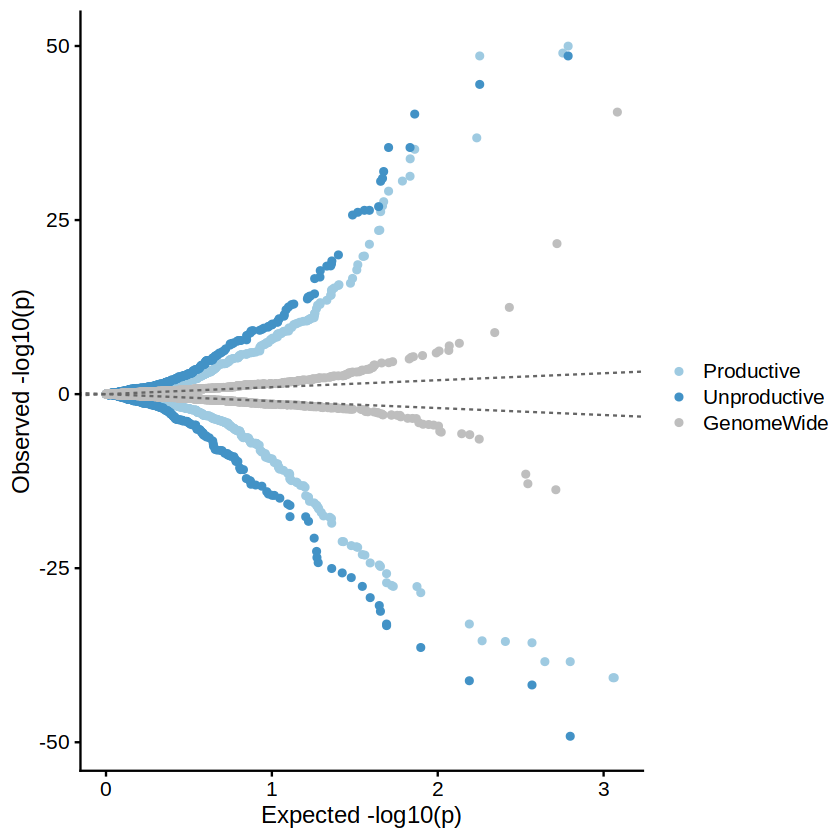

In [42]:
qqplot

In [43]:
dim(plotDF)
plotDF[1:5]
unique(plotDF) %>% dim()


[1] 1851    9

gid,intron_id,gene_id,pval_sqtl,pval_eqtl,slope_sqtl,slope_eqtl,ctype,topflag
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
chr1_1005757_AGCCCCCGCAGCAGT_A_b38,chr1:999787:999865:clu_1926_-:PR,ENSG00000188290.11,1.18220e-20,4.48026e-03,-0.823307,0.182951,PR,0
chr1_1098863_C_T_b38,chr1:1106049:1116059:clu_1931_-:PR,ENSG00000131591.17,9.29591e-06,3.53651e-11,0.634475,-0.513621,PR,0
chr1_1239126_C_CT_b38,chr1:1217804:1218457:clu_1933_-:PR,ENSG00000078808.18,7.39121e-07,8.46434e-03,-0.755286,0.249504,PR,0
chr1_1489916_C_T_b38,chr1:1487914:1489203:clu_29_+:PR,ENSG00000160072.20,2.07228e-06,2.89073e-04,-0.687844,0.296692,PR,0
chr1_1686882_T_C_b38,chr1:1707599:1708179:clu_1970_-:UP,ENSG00000008128.23,4.49999e-07,1.70568e-01,0.416030,-0.109808,"PR,UP",0


[1] 1851    9

In [44]:
corr <- plotDF[, .(slope_sqtl, slope_eqtl, ctype = if_else(ctype == "PR", "PR", "UP"))] %>%
  split(by = "ctype") %>%
  map(~ cor.test(x = .x$slope_eqtl, y = .x$slope_sqtl, method = "pearson"))


In [45]:
corr$UP$p.value


[1] 2.117581e-08

In [46]:
corr


$PR

	Pearson's product-moment correlation

data:  .x$slope_eqtl and .x$slope_sqtl
t = -0.56184, df = 1238, p-value = 0.5743
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.07157155  0.03973831
sample estimates:
        cor 
-0.01596609 


$UP

	Pearson's product-moment correlation

data:  .x$slope_eqtl and .x$slope_sqtl
t = -5.6774, df = 609, p-value = 2.118e-08
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2982213 -0.1475080
sample estimates:
       cor 
-0.2242048 



In [47]:
library(ggpointdensity)


In [48]:
corr <- plotDF[, .(slope_sqtl, slope_eqtl, ctype = if_else(ctype == "PR", "PR", "UP"))] %>%
  split(by = "ctype") %>%
  map(~ cor.test(x = .x$slope_eqtl, y = .x$slope_sqtl, method = "s"))

corr.pvals <- map(corr, ~ .x$p.value) %>% unlist()
corr.estimates <- map(corr, ~ .x$estimate[[1]]) %>% unlist()

if (all(names(corr.pvals) == names(corr.estimates))) {
  corr.df <- data.frame(
    ctype = if_else(names(corr.pvals) == "PR", "Productive", "Unproductive"),
    pval = corr.pvals,
    estimate = corr.estimates
  )
} else {
  stop("names of pvals and estimates do not match")
}


Warning message in cor.test.default(x = .x$slope_eqtl, y = .x$slope_sqtl, method = "s"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = .x$slope_eqtl, y = .x$slope_sqtl, method = "s"):
“Cannot compute exact p-value with ties”


In [49]:
corr.df <- corr.df %>%
  mutate(xpos = c(0, 0), ypos = c(0, 0))
corr.df


,ctype,pval,estimate,xpos,ypos
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
PR,Productive,6.892108e-01,-0.01136824,0,0
UP,Unproductive,4.225541e-05,-0.16486019,0,0


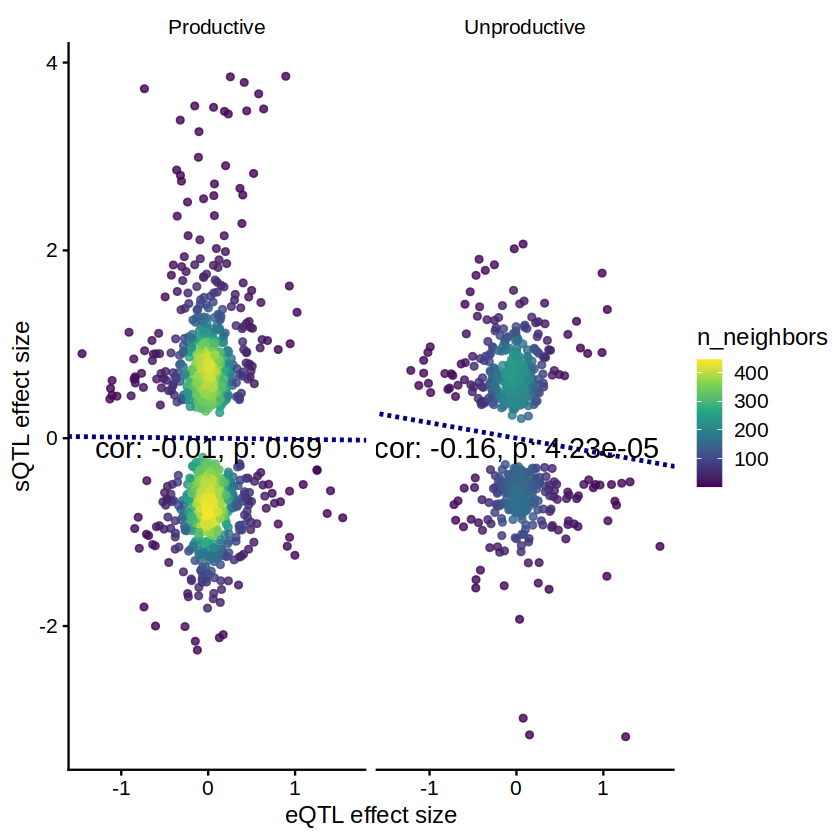

In [50]:
plotDF[, .(slope_sqtl, slope_eqtl, ctype)] %>%
  mutate(ctype = if_else(ctype == "PR", "Productive", "Unproductive")) %>%
  # .[ctype == "Productive"] %>%
  ggplot() +
  geom_pointdensity(aes(slope_eqtl, slope_sqtl), alpha = .8) +
  geom_abline(aes(intercept = 0, slope = estimate), data = corr.df, linetype = "dashed", color = 'navy', linewidth = 1) +
  scale_color_viridis_c() +
  labs(x = "eQTL effect size", y = "sQTL effect size") +
  geom_text(
    aes(
      x = xpos, y = ypos,
      label = glue("cor: {corr}, p: {pvalue}",
        corr = if_else(abs(estimate) > .001, scales::number(estimate, .01), scales::scientific(estimate)),
        pvalue = if_else(pval > .001, scales::number(pval, .01), scales::scientific(pval))
      )
    ),
    data = corr.df, size = 6, hjust = .5, vjust = 1
  ) +
  theme_cowplot() +
  facet_wrap(~ctype) +
  theme(strip.background = element_rect(fill = "white"))


In [117]:
sqtl.gr <- sqtl[, .(phenotype_chr, phenotype_start, phenotype_end, phenotype_strand, phenotype_id)]
sqtl.gr <- makeGRangesFromDataFrame(sqtl.gr,
  keep.extra.columns = TRUE, seqnames.field = "phenotype_chr",
  start.field = "phenotype_start", end.field = "phenotype_end",
  strand.field = "phenotype_strand"
)


In [132]:
sqtl.gr %>% sort()


GRanges object with 2320 ranges and 1 metadata column:
         seqnames            ranges strand |           phenotype_id
            <Rle>         <IRanges>  <Rle> |            <character>
     [1]     chr1     941307-942135      + | chr1:941306:942135:c..
     [2]     chr1   2156093-2169517      + | chr1:2156092:2169517..
     [3]     chr1   6448562-6448640      + | chr1:6448561:6448640..
     [4]     chr1   6449092-6451602      + | chr1:6449091:6451602..
     [5]     chr1   6580050-6580540      + | chr1:6580049:6580540..
     ...      ...               ...    ... .                    ...
  [2316]    chr22 50284666-50285799      - | chr22:50284665:50285..
  [2317]    chr22 50526142-50526245      - | chr22:50526141:50526..
  [2318]    chr22 50571293-50571374      - | chr22:50571292:50571..
  [2319]    chr22 50571534-50572005      - | chr22:50571533:50572..
  [2320]    chr22 50782348-50783500      - | chr22:50782347:50783..
  -------
  seqinfo: 22 sequences from an unspecified genome;

In [121]:
nom.gr <- nomDF[, .(pid, pchr, pstart, pend, pstrand)] %>% unique()
nom.gr <- makeGRangesFromDataFrame(nom.gr,
  keep.extra.columns = TRUE, seqnames.field = "pchr",
  start.field = "pstart", end.field = "pend",
  strand.field = "pstrand"
)


In [124]:
sort(sqtl.gr)


GRanges object with 2320 ranges and 1 metadata column:
         seqnames            ranges strand |           phenotype_id
            <Rle>         <IRanges>  <Rle> |            <character>
     [1]     chr1     941307-942135      + | chr1:941306:942135:c..
     [2]     chr1   2156093-2169517      + | chr1:2156092:2169517..
     [3]     chr1   6448562-6448640      + | chr1:6448561:6448640..
     [4]     chr1   6449092-6451602      + | chr1:6449091:6451602..
     [5]     chr1   6580050-6580540      + | chr1:6580049:6580540..
     ...      ...               ...    ... .                    ...
  [2316]    chr22 50284666-50285799      - | chr22:50284665:50285..
  [2317]    chr22 50526142-50526245      - | chr22:50526141:50526..
  [2318]    chr22 50571293-50571374      - | chr22:50571292:50571..
  [2319]    chr22 50571534-50572005      - | chr22:50571533:50572..
  [2320]    chr22 50782348-50783500      - | chr22:50782347:50783..
  -------
  seqinfo: 22 sequences from an unspecified genome;

In [140]:
x <- GenomicRanges::distanceToNearest(sqtl.gr, nom.gr, select = "arbitrary", ignore.strand = TRUE)


In [141]:
x


Hits object with 2320 hits and 1 metadata column:
         queryHits subjectHits |  distance
         <integer>   <integer> | <integer>
     [1]         1          38 |      2067
     [2]         2          31 |         0
     [3]         3          31 |         0
     [4]         4          22 |         0
     [5]         5          15 |         0
     ...       ...         ... .       ...
  [2316]      2316       11556 |         0
  [2317]      2317       11563 |         0
  [2318]      2318       11558 |         0
  [2319]      2319       11558 |         0
  [2320]      2320       11560 |         0
  -------
  queryLength: 2320 / subjectLength: 11586

In [143]:
x$metada


ERROR: Error in x$metadata: $ operator not defined for this S4 class


In [98]:
sqtl[, .(Nclu = uniqueN(clu)), by = .(ctype)]
sqtl[, .(Nclu = uniqueN(clu)), by = .(qtl_type)]


ctype,Nclu
<chr>,<int>
PR,1313
"PR,UP",1007


qtl_type,Nclu
<chr>,<int>
p-sQTL,1313
u-sQTL,1007


In [443]:
cnts <- fread('../code/resources/GTEx/expression/Brain-Hypothalamus_gene_reads.tsv.gz')

In [444]:
dim(cnts)
cnts[1:5]

[1] 56200   204

Name,Description,GTEX-1192X-0011-R8b-SM-DO11U,GTEX-11DXY-0011-R8a-SM-DO11M,GTEX-11DYG-0011-R8a-SM-DO93F,GTEX-11DZ1-0011-R8b-SM-DNZZI,GTEX-11EI6-0011-R8a-SM-DO93M,GTEX-11EMC-0011-R8b-SM-DO91Z,GTEX-11GSP-0011-R8b-SM-5NQ79,GTEX-11H98-0011-R8a-SM-5NQ8V,⋯,GTEX-YFC4-0011-R8a-SM-4SOK3,GTEX-YJ89-0011-R8b-SM-4SOK8,GTEX-Z93S-0011-R8a-SM-4RGNL,GTEX-ZAB4-0011-R8b-SM-4SOKF,GTEX-ZDXO-0011-R8a-SM-4WWD7,GTEX-ZF28-0011-R8a-SM-4WWFW,GTEX-ZUA1-0011-R8b-SM-51MST,GTEX-ZVT3-0011-R8b-SM-57WDJ,GTEX-ZVZQ-0011-R8a-SM-51MR5,GTEX-ZXG5-0011-R8a-SM-57WD1
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000223972.5,DDX11L1,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,1
ENSG00000227232.5,WASH7P,86,89,108,52,42,54,70,31,⋯,114,101,67,172,95,71,96,45,89,159
ENSG00000278267.1,MIR6859-1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000243485.5,MIR1302-2HG,1,2,1,0,1,0,1,1,⋯,1,0,0,0,0,0,2,5,1,2
ENSG00000237613.2,FAM138A,1,0,1,0,0,0,1,0,⋯,0,1,0,0,0,0,0,0,0,3


In [448]:
colnames(cnts) %>% head(10)

[1] "Name"                         "Description"                 
 [3] "GTEX-1192X-0011-R8b-SM-DO11U" "GTEX-11DXY-0011-R8a-SM-DO11M"
 [5] "GTEX-11DYG-0011-R8a-SM-DO93F" "GTEX-11DZ1-0011-R8b-SM-DNZZI"
 [7] "GTEX-11EI6-0011-R8a-SM-DO93M" "GTEX-11EMC-0011-R8b-SM-DO91Z"
 [9] "GTEX-11GSP-0011-R8b-SM-5NQ79" "GTEX-11H98-0011-R8a-SM-5NQ8V"

In [449]:
colnames(cnts) %>% head(10) %>% 
gsub("-(\\w+)-(\\w+)-(\\w+)-(\\w+)", "-\\1", .)

[1] "Name"             "Description"      "GTEX-1192X-DO11U" "GTEX-11DXY-DO11M"
 [5] "GTEX-11DYG-DO93F" "GTEX-11DZ1-DNZZI" "GTEX-11EI6-DO93M" "GTEX-11EMC-DO91Z"
 [9] "GTEX-11GSP-5NQ79" "GTEX-11H98-5NQ8V"

In [1]:
colnames(cnts) %>% 
str_extract("Name|Description|GTEX\\-[\\w\\d]+")

ERROR: Error in colnames(cnts) %>% str_extract("Name|Description|GTEX\\-[\\w\\d]+"): could not find function "%>%"
